<a href="https://colab.research.google.com/github/mehmetkesik/tensorflow-basics/blob/main/06_transfer_learning_in_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're using a GPU
!nvidia-smi

Sun Dec  4 10:39:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [1]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import *

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [2]:
if Path("101_food_classes_10_percent").is_dir():
    print("101_food_classes_10_percent already exist, skipping donwload...")
else:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-12-05 05:45:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.251.167.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   161MB/s    in 9.5s    

2022-12-05 05:45:58 (163 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_perc

In [3]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
IMG_SIZE = (224, 224)
train_data_all_10_percent = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [4]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [5]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback]
                                           )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3719 - accuracy: 0.2709

237/237 [==============================] - 132s 497ms/step - loss: 3.3719 - accuracy: 0.2709 - val_loss: 2.5094 - val_accuracy: 0.4251
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.2111 - accuracy: 0.4891

237/237 [==============================] - 100s 422ms/step - loss: 2.2111 - accuracy: 0.4891 - val_loss: 2.0713 - val_accuracy: 0.4944
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8147 - accuracy: 0.5688

237/237 [==============================] - 97s 406ms/step - loss: 1.8147 - accuracy: 0.5688 - val_loss: 1.9199 - val_accuracy: 0.5095
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.6057 - accuracy: 0.6136

237/237 [==============================] - 93s 390ms/step - loss: 1.6057 - accuracy: 0.6136 - val_loss: 1.8414 - val_accuracy: 0.5286
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4497 - accuracy: 0.6418

237/237 [==============================] - 91s 382ms/step - loss: 1.4497 - accuracy: 0.6418 - val_loss: 1.7744 - val_accuracy: 0.5418


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 62s 79ms/step - loss: 1.5736 - accuracy: 0.5877


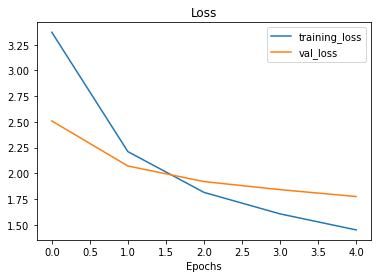

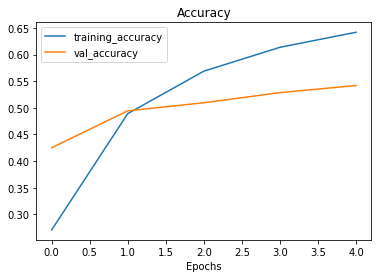

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

The more layers we make trainable in the basic model, the more we should reduce the learning rate:
- last 5 layer trainable => lr=0.0001
- last 10 layer trainable => lr=0.000025

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
          epochs=fine_tune_epochs,
          initial_epoch=history_all_classes_10_percent.epoch[-1],
          validation_data=test_data,
          validation_steps=int(0.15 * len(test_data)))

Epoch 5/10
237/237 [==============================] - 61s 227ms/step - loss: 1.2047 - accuracy: 0.6874 - val_loss: 1.7679 - val_accuracy: 0.5315
Epoch 6/10
237/237 [==============================] - 50s 211ms/step - loss: 1.0960 - accuracy: 0.7104 - val_loss: 1.7337 - val_accuracy: 0.5458
Epoch 7/10
237/237 [==============================] - 49s 203ms/step - loss: 1.0121 - accuracy: 0.7315 - val_loss: 1.7478 - val_accuracy: 0.5379
Epoch 8/10
237/237 [==============================] - 47s 194ms/step - loss: 0.9504 - accuracy: 0.7526 - val_loss: 1.7602 - val_accuracy: 0.5376
Epoch 9/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8741 - accuracy: 0.7651 - val_loss: 1.6769 - val_accuracy: 0.5569
Epoch 10/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8427 - accuracy: 0.7765 - val_loss: 1.7143 - val_accuracy: 0.5487


In [ ]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 60s 76ms/step - loss: 1.4811 - accuracy: 0.6052


[1.4810616970062256, 0.6052277088165283]

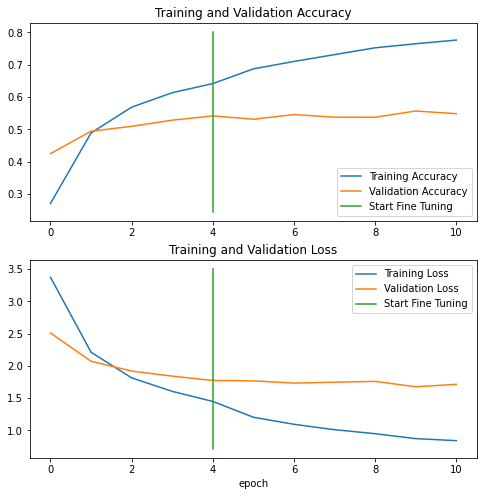

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model
model.save("drive/MyDrive/tensorflow-course/101_food_classes_10_percent_save_big_dog_model")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow-course/101_food_classes_10_percent_save_big_dog_model")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 62s 77ms/step - loss: 1.4811 - accuracy: 0.6052


[1.4810616970062256, 0.6052277088165283]

## Evaluating the performance of the big dog model across all diffirent classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [6]:
import tensorflow as tf
!wget https://github.com/mehmetkesik/tensorflow-basics/raw/main/101_food_classes_10_percent_save_big_dog_model.zip

--2022-12-05 05:47:09--  https://github.com/mehmetkesik/tensorflow-basics/raw/main/101_food_classes_10_percent_save_big_dog_model.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/101_food_classes_10_percent_save_big_dog_model.zip [following]
--2022-12-05 05:47:09--  https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/101_food_classes_10_percent_save_big_dog_model.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22765987 (22M) [application/zip]
Saving to: ‘101_food_classes_10_percent_save_big_dog_model.zip’

101_food_classes_10 100%[======

In [7]:
unzip_data("101_food_classes_10_percent_save_big_dog_model.zip")

In [8]:
model = tf.keras.models.load_model("101_food_classes_10_percent_save_big_dog_model")

In [9]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 1809s 2s/step - loss: 1.4811 - accuracy: 0.6052


[1.481061577796936, 0.6052277088165283]

## Making predictions with our trained model

In [10]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 1831s 2s/step


In [11]:
len(test_data)

790

In [12]:
# How many predictions are there?
len(preds_probs)

25250

In [13]:
# What's the shape of our predicitons?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[3.5733056e-01, 2.2244583e-04, 4.4882342e-02, ..., 8.0612235e-06,
        2.8739274e-03, 3.4216955e-02],
       [9.4799817e-01, 2.4115849e-08, 2.3473785e-04, ..., 1.6615693e-03,
        1.7921985e-07, 6.6646289e-06],
       [5.6018925e-01, 8.3419727e-03, 1.1631736e-02, ..., 2.9301626e-04,
        2.8722498e-04, 1.3563816e-03],
       ...,
       [1.8319680e-01, 9.2692208e-06, 1.1140279e-03, ..., 5.1760953e-02,
        2.2827012e-03, 2.1323681e-04],
       [2.4712285e-01, 4.6694139e-04, 1.6584204e-01, ..., 4.8358075e-04,
        6.0568779e-04, 2.9093967e-04],
       [7.3314905e-01, 4.4662679e-07, 4.4876611e-04, ..., 4.0741106e-03,
        1.5556818e-06, 6.3364918e-04]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.57330561e-01, 2.22445829e-04, 4.48823422e-02, 1.19536836e-07,
        9.47997250e-06, 3.34606261e-06, 8.81148517e-05, 3.01055593e-06,
        8.05690791e-03, 3.79745150e-04, 8.83982352e-07, 1.57365612e-05,
        3.86553816e-04, 1.21888047e-06, 2.18820013e-03, 1.83415471e-03,
        1.56925016e-05, 1.38874806e-03, 9.93092358e-03, 1.14326740e-05,
        1.32563431e-03, 8.15927251e-06, 1.38379895e-04, 6.33779491e-05,
        8.03409377e-04, 3.12819867e-03, 1.16629328e-03, 4.90902821e-05,
        2.05209911e-01, 1.02361292e-03, 5.44909426e-06, 1.30379712e-03,
        4.68529324e-04, 4.68316841e-07, 6.73545245e-03, 6.38221445e-06,
        1.93415108e-04, 5.50932484e-03, 3.30993086e-02, 1.61946431e-04,
        5.35341678e-04, 6.60830270e-03, 3.29285482e-04, 3.53633623e-05,
        2.77618499e-04, 1.48502204e-05, 9.64801176e-04, 1.27962412e-04,
        4.32964725e-06, 2.65805349e-02, 3.16959311e-04, 8.67930285e-05,
        5.63567057e-02, 5.20798713e-02, 9.11398820e-05, 1.606040

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passedto the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.57330561e-01 2.22445829e-04 4.48823422e-02 1.19536836e-07
 9.47997250e-06 3.34606261e-06 8.81148517e-05 3.01055593e-06
 8.05690791e-03 3.79745150e-04 8.83982352e-07 1.57365612e-05
 3.86553816e-04 1.21888047e-06 2.18820013e-03 1.83415471e-03
 1.56925016e-05 1.38874806e-03 9.93092358e-03 1.14326740e-05
 1.32563431e-03 8.15927251e-06 1.38379895e-04 6.33779491e-05
 8.03409377e-04 3.12819867e-03 1.16629328e-03 4.90902821e-05
 2.05209911e-01 1.02361292e-03 5.44909426e-06 1.30379712e-03
 4.68529324e-04 4.68316841e-07 6.73545245e-03 6.38221445e-06
 1.93415108e-04 5.50932484e-03 3.30993086e-02 1.61946431e-04
 5.35341678e-04 6.60830270e-03 3.29285482e-04 3.53633623e-05
 2.77618499e-04 1.48502204e-05 9.64801176e-04 1.27962412e-04
 4.32964725e-06 2.65805349e-02 3.16959311e-04 8.67930285e-05
 5.63567057e-02 5.20798713e-02 9.11398820e-05 1.60604045e-02
 8.14285967e-03 3.12969042e-03 4.01541917e-

In [ ]:
test_data.class_names[0]

'apple_pie'

In [14]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  0,  8, 78, 29, 46,  0,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [15]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for _, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, ..., 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [17]:
# Let's try scikit-learn's accuracy score functions and see what it come up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6052277227722772

In [18]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

Let's get visual: making a confusion matrix

In [23]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

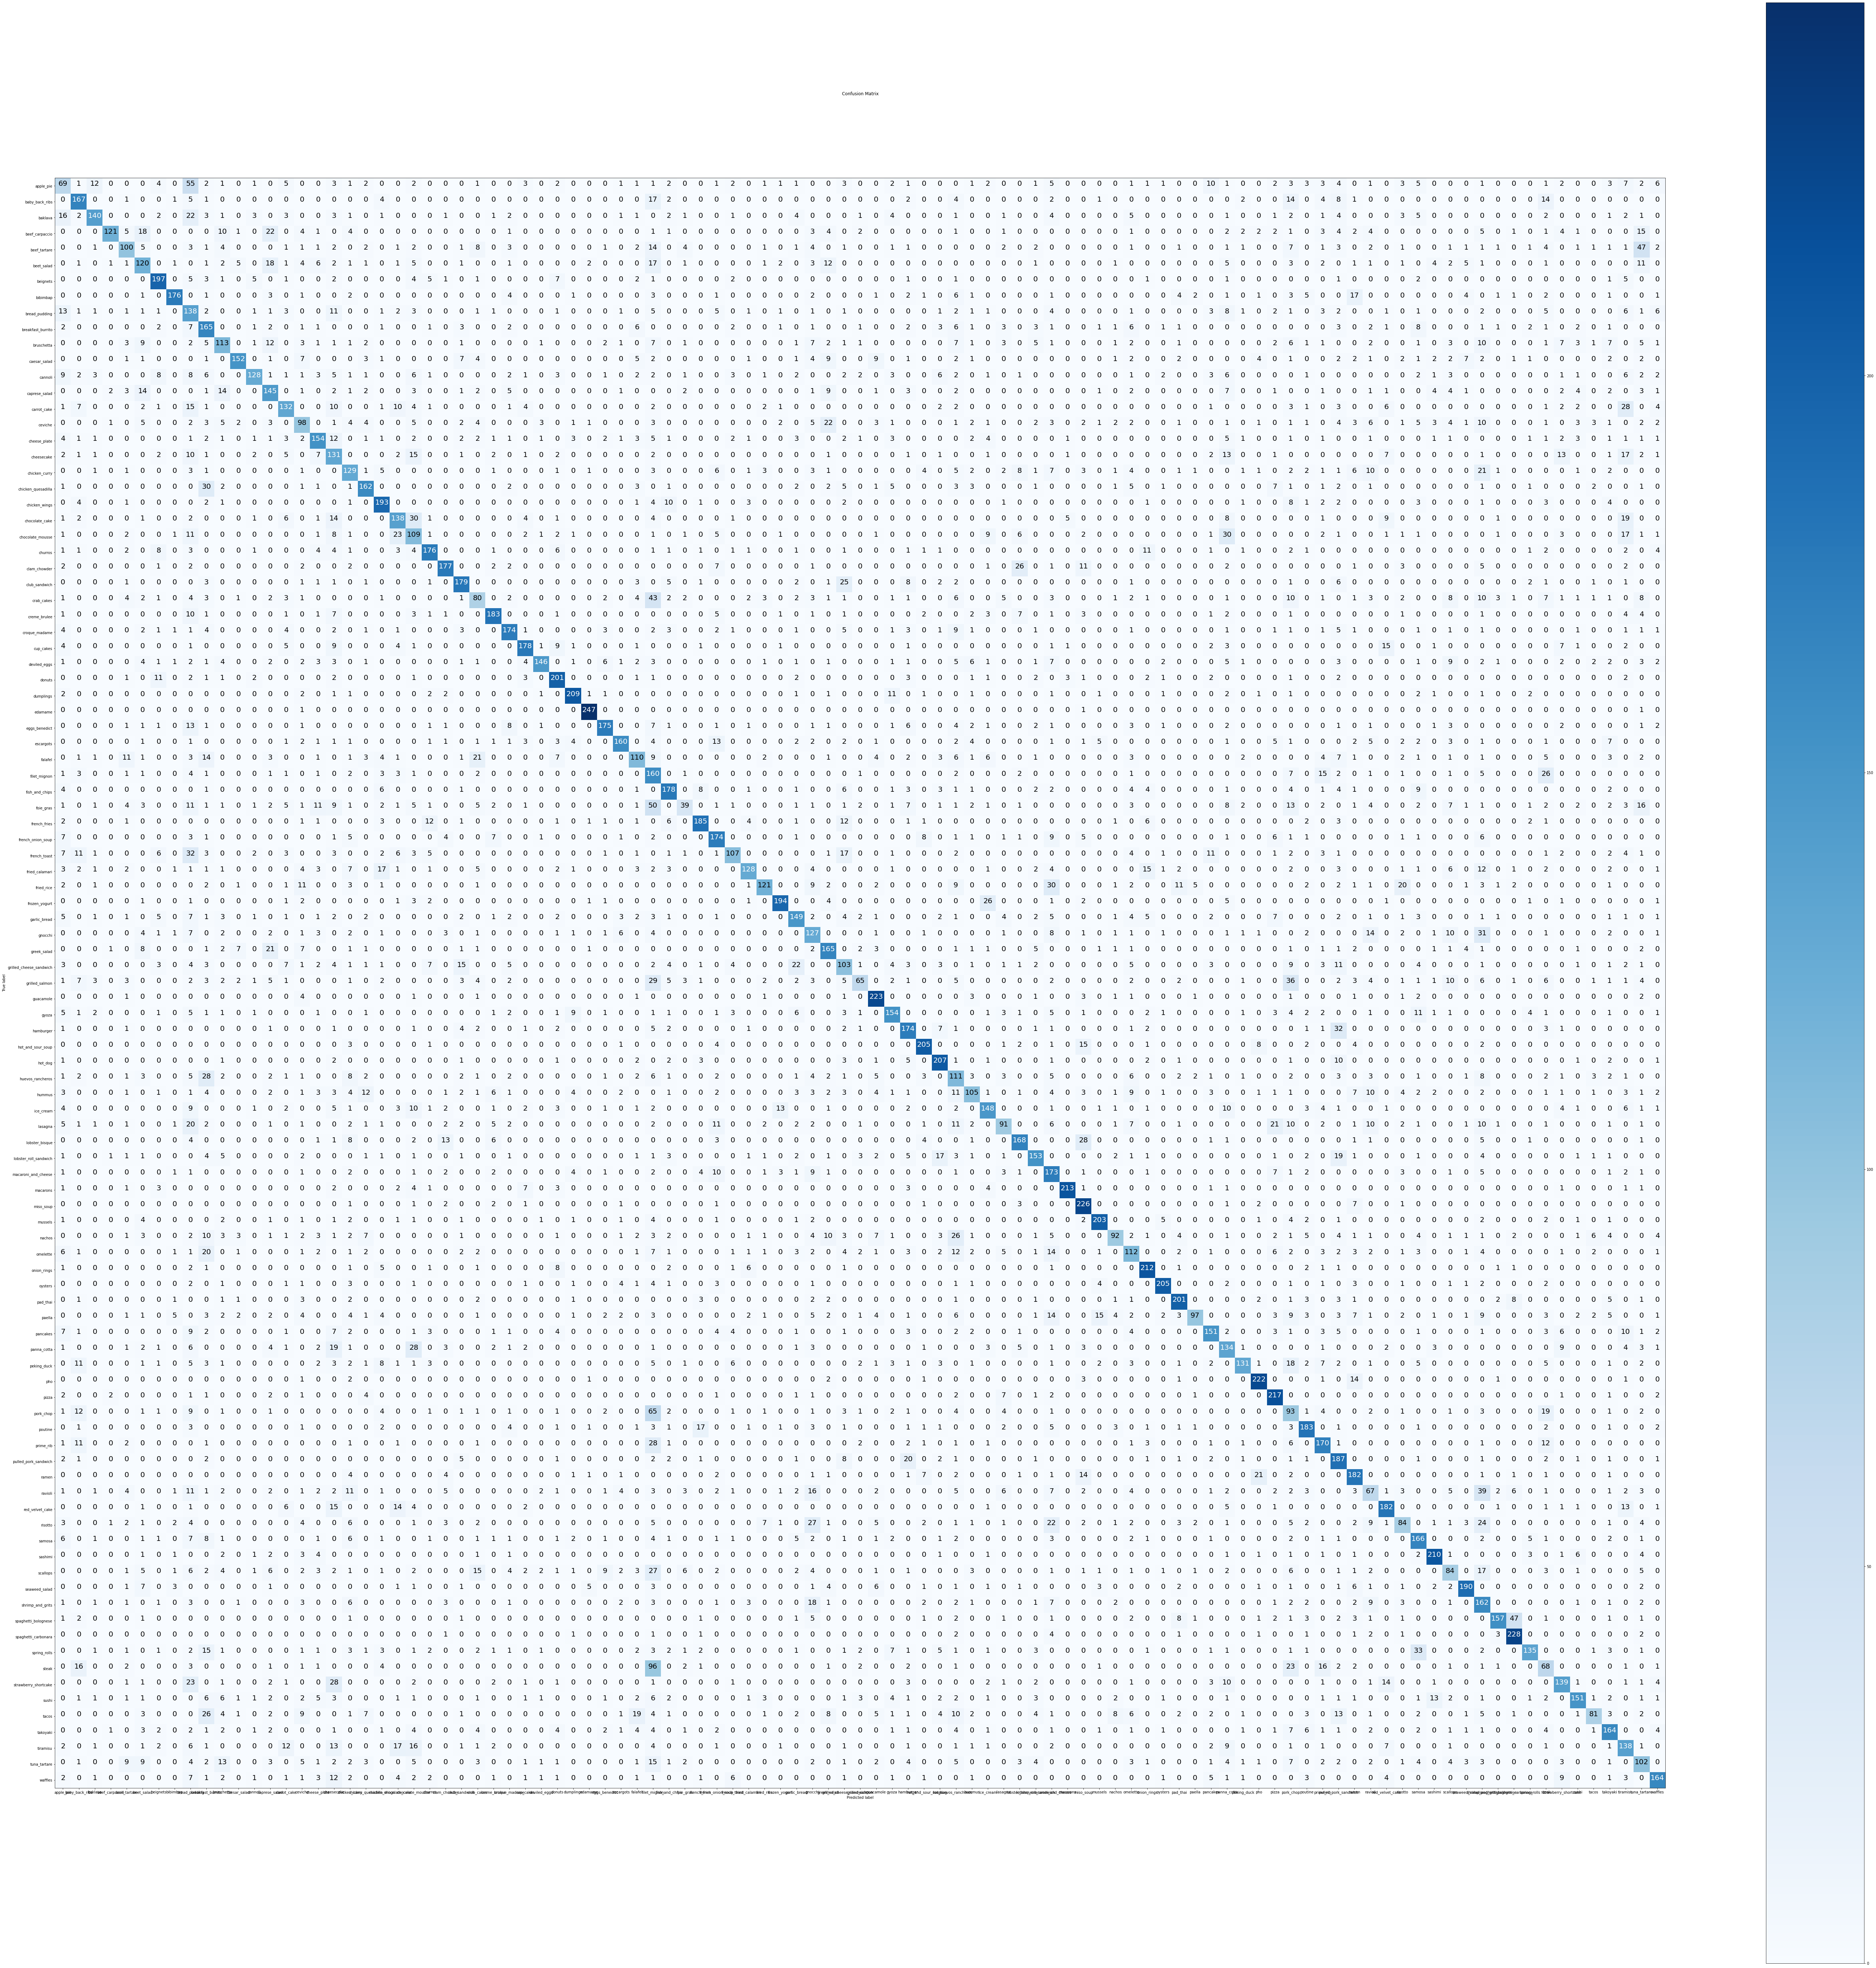

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g precision, recall and F1) called classification report, let's try it out.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       250
           1       0.60      0.67      0.63       250
           2       0.78      0.56      0.65       250
           3       0.92      0.48      0.64       250
           4       0.54      0.40      0.46       250
           5       0.47      0.48      0.47       250
           6       0.73      0.79      0.76       250
           7       0.88      0.70      0.78       250
           8       0.24      0.55      0.34       250
           9       0.39      0.66      0.49       250
          10       0.49      0.45      0.47       250
          11       0.84      0.61      0.71       250
          12       0.81      0.51      0.63       250
          13       0.51      0.58      0.54       250
          14       0.59      0.53      0.56       250
          15       0.44      0.39      0.42       250
          16       0.63      0.62      0.62       250
          17       0.35    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [21]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2974137931034483,
  'recall': 0.276,
  'f1-score': 0.2863070539419087,
  'support': 250},
 '1': {'precision': 0.6028880866425993,
  'recall': 0.668,
  'f1-score': 0.6337760910815939,
  'support': 250},
 '2': {'precision': 0.7821229050279329,
  'recall': 0.56,
  'f1-score': 0.6526806526806528,
  'support': 250},
 '3': {'precision': 0.9236641221374046,
  'recall': 0.484,
  'f1-score': 0.6351706036745406,
  'support': 250},
 '4': {'precision': 0.5376344086021505,
  'recall': 0.4,
  'f1-score': 0.45871559633027525,
  'support': 250},
 '5': {'precision': 0.46875,
  'recall': 0.48,
  'f1-score': 0.4743083003952569,
  'support': 250},
 '6': {'precision': 0.7269372693726938,
  'recall': 0.788,
  'f1-score': 0.7562380038387716,
  'support': 250},
 '7': {'precision': 0.88,
  'recall': 0.704,
  'f1-score': 0.7822222222222222,
  'support': 250},
 '8': {'precision': 0.24338624338624337,
  'recall': 0.552,
  'f1-score': 0.3378212974296206,
  'support': 250},
 '9': {'precision':

Let's plot all of our classes F1-scores...

In [24]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class name and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2863070539419087,
 'baby_back_ribs': 0.6337760910815939,
 'baklava': 0.6526806526806528,
 'beef_carpaccio': 0.6351706036745406,
 'beef_tartare': 0.45871559633027525,
 'beet_salad': 0.4743083003952569,
 'beignets': 0.7562380038387716,
 'bibimbap': 0.7822222222222222,
 'bread_pudding': 0.3378212974296206,
 'breakfast_burrito': 0.4903417533432393,
 'bruschetta': 0.4718162839248434,
 'caesar_salad': 0.705336426914153,
 'cannoli': 0.6259168704156479,
 'caprese_salad': 0.5400372439478583,
 'carrot_cake': 0.559322033898305,
 'ceviche': 0.4152542372881356,
 'cheese_plate': 0.6222222222222221,
 'cheesecake': 0.4165341812400636,
 'chicken_curry': 0.4942528735632184,
 'chicken_quesadilla': 0.6694214876033059,
 'chicken_wings': 0.7188081936685289,
 'chocolate_cake': 0.5598377281947262,
 'chocolate_mousse': 0.39421338155515373,
 'churros': 0.7242798353909465,
 'clam_chowder': 0.7344398340248962,
 'club_sandwich': 0.7117296222664016,
 'crab_cakes': 0.365296803652968,
 'creme_brulee':

In [27]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [29]:
f1_scores

,class_names,f1-score
33,edamame,0.962963
63,macarons,0.898734
69,oysters,0.852391
75,pho,0.847328
32,dumplings,0.837675
...,...,...
82,ravioli,0.301124
77,pork_chop,0.299517
0,apple_pie,0.286307
93,steak,0.280992


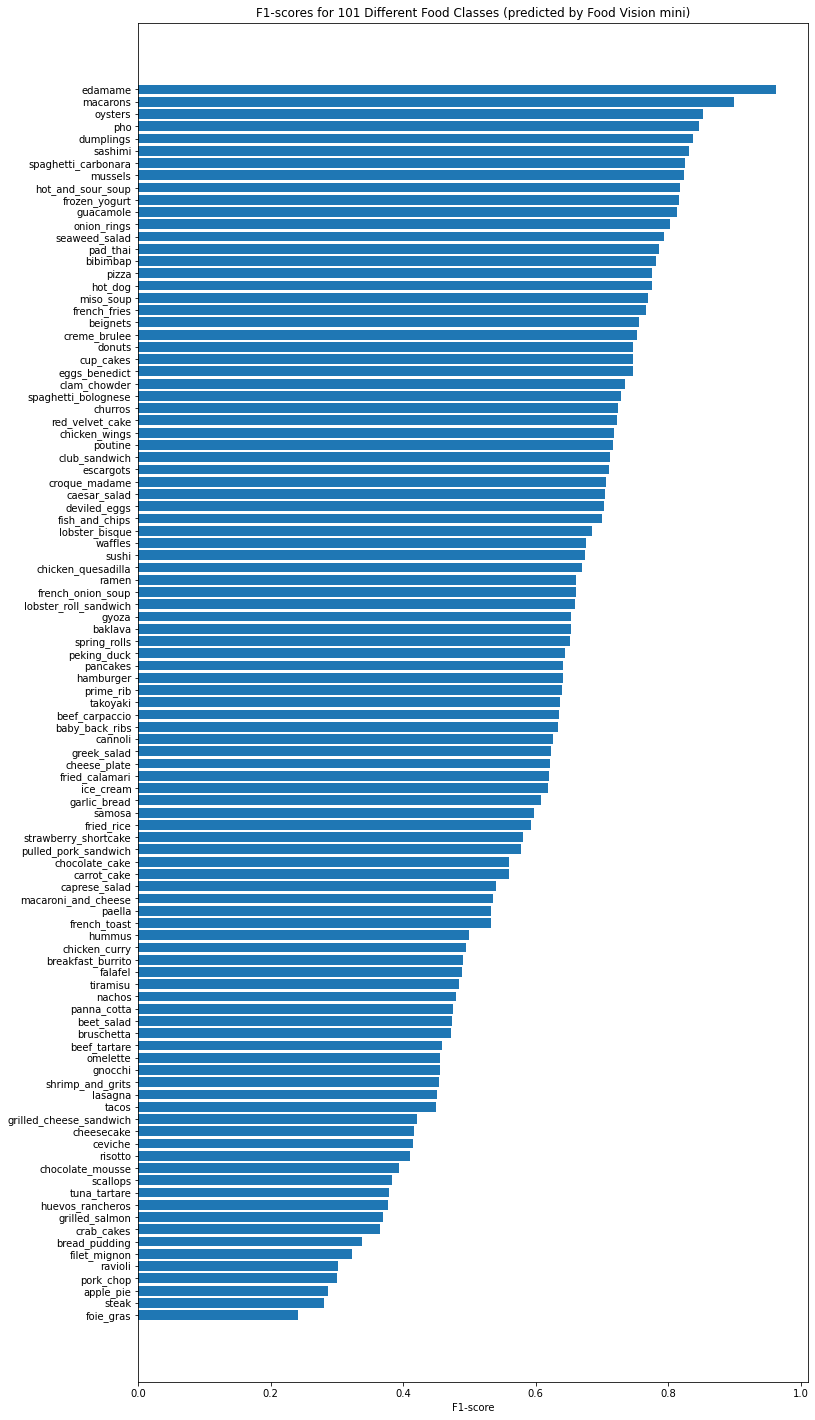

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values 
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, spesifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [37]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  return img # don't need to rescale images for EfficientNet model in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 129ms/step


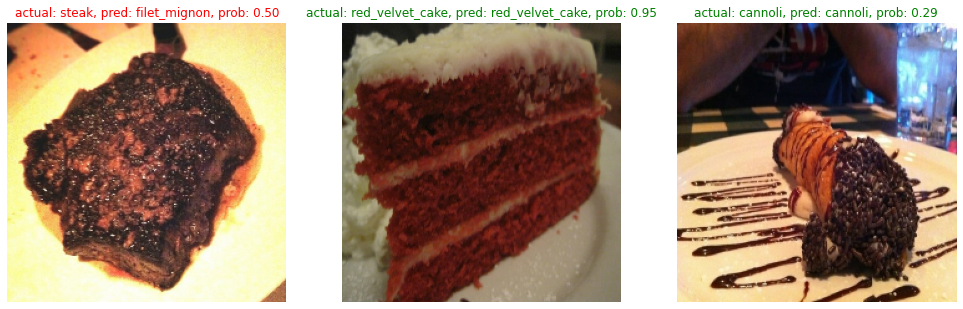

In [65]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the images filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities,prediction class names, ground truth class names.
3. User our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [67]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [68]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.357332,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.947998,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.560189,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.202983,apple_pie,apple_pie
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.515009,apple_pie,bread_pudding
...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.973207,waffles,waffles
25246,b'101_food_classes_10_percent/test/waffles/954...,100,16,0.916456,waffles,cheese_plate
25247,b'101_food_classes_10_percent/test/waffles/961...,100,100,0.408236,waffles,waffles
25248,b'101_food_classes_10_percent/test/waffles/970...,100,94,0.386891,waffles,strawberry_shortcake


In [69]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.357332,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.947998,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.560189,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.202983,apple_pie,apple_pie,True
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.515009,apple_pie,bread_pudding,False


In [71]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.998969,sushi,sashimi,False
11642,b'101_food_classes_10_percent/test/garlic_brea...,46,10,0.998397,garlic_bread,bruschetta,False
191,b'101_food_classes_10_percent/test/apple_pie/3...,0,31,0.998288,apple_pie,donuts,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.998192,fried_calamari,onion_rings,False
9110,b'101_food_classes_10_percent/test/falafel/241...,36,31,0.997287,falafel,donuts,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.995918,paella,mussels,False
15826,b'101_food_classes_10_percent/test/macarons/19...,63,29,0.995573,macarons,cup_cakes,False
8794,b'101_food_classes_10_percent/test/escargots/1...,35,41,0.994904,escargots,french_onion_soup,False
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.994512,scallops,cup_cakes,False
15142,b'101_food_classes_10_percent/test/lobster_bis...,60,64,0.993548,lobster_bisque,miso_soup,False


In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability